# Train CDER models and ML classifier  
Author: Amish Mishra  
Date: April 4, 2023  
Use `cder2` kernel  
This notebook loads in the PDs for the proteins, trains CDER models for each topology to distinguish stable from unstable proteins, and then trains an ML classifier on the CDER coordinate evaluations on a test set

In [3]:
import time
import pickle
import pandas
import multidim
import numpy as np
from sklearn import metrics
from multidim.models import CDER
from multidim.covertree import CoverTree
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import scipy.stats as sps
from sklearn import model_selection
from IPython.display import display

In [4]:
def stability_threshold_labeller(label_col_value, thresh=1.0):
    '''
    Takes a stability score and returns a lable for it depending on a threshold
    '''
    if label_col_value > thresh:
        return "green"
    else:
        return "red"
    

def preprocess_pd(pd, skew=False, filter='top', t=10):
    """
    Transform a diagram into birth-death coordinates and/or filter out low persistence pairs
    :param pd: Nx2 numpy array of persistence pairs
    :param skew: boolean flag to return point clouds in birth-death coordinates or birth-persistence coordinates
    :param filter: string specifying the type of filtering to do
                   'top': retain at most the t most persistent pairs,
                   'threshold': retain pairs with persistence above t
    :param t: value of filtering parameter
    :return: the processed pd, the number of pairs retained
    """
    num_pairs = None
    if pd.shape[1] == 1:  # This is the case for the H_0 persistence pairs which are 1-dim arrays
        pers = pd[:, 0]
    else:
        pers = pd[:, 1] - pd[:, 0]
        
    if filter == 'threshold':
        pd_new = pd[pers > t, :]
    elif filter == 'all':
        pd_new = pd
        num_pairs = len(pd)
    elif filter == 'top':
        pd_new = pd[np.argsort(pers), :]
        if len(pers) > t:
            pd_new = pd_new[len(pers)-t:, :]
        num_pairs = t
    elif filter == 'random_pairs':
        number_of_rows = pd.shape[0]
        random_indices = np.random.choice(number_of_rows, size=t, replace=False)
        pd_new = pd[random_indices, :]
    elif filter == 'random_percent':
        number_of_rows = pd.shape[0]
        num_pairs = int(np.ceil(number_of_rows*t))
        random_indices = np.random.choice(number_of_rows, size=num_pairs, replace=False)
        pd_new = pd[random_indices, :]

    # convert pd to (birth, persistence) pairs
    if skew and pd.shape[1] != 1:
        pd_new[:, 1] = pd_new[:, 1] - pd_new[:, 0]
    return pd_new, num_pairs


def preprocess_pd_array(pd_array, skew=False, filter='top', t=10):
    """
    Transform the diagrams contained in a diagram array whose keys are equal to homological dimension
    into birth-death coordinates and/or filter out low persistence pairs
    :param pd_array: array of persistence diagrams in a fixed dimention, i.e. value in one entry in the 
                     the dictionary output of load_pd_pcs()
    :param skew: boolean flag to return point clouds in birth-death coordinates or birth-persistence coordinates
    :param filter: string specifying the type of filtering to do 
                   'top': retain at most the t most persistent pairs,
                   'threshold': retain pairs with persistence above t
    :param t: value of filtering parameter
    :return: the processed pd array, the number of pairs retained in each pd
    """
    pd_array_new = []
    num_pairs_arr = []
    # loop over each diagram in the list of diagrams in this dimension and process
    for pd in pd_array:
        filtered_pd, num_pairs_retained = preprocess_pd(pd, skew=skew, filter=filter, t=t)
        pd_array_new.append(filtered_pd)
        num_pairs_arr.append(num_pairs_retained)
    
    return pd_array_new, num_pairs_arr


def gen_cder_model(clouds, labels, stop_level=None, parsimonious=True, full_ct=True, out_file=None):
    """
    Generates and optionally saves a cder model
    :param clouds: Nx1 list of numpy arrays of point clouds
    :param labels: Nx1 list of labels of the point clouds
    :param stop_level: integer specifying the cover tree level at which to stop (only applies if full_ct=False)
    :param parsimonious: boolean flag specifying parsimonious and full cder model
    :param full_ct: boolean flag specifying if full cover tree should be built
    :param out_file: path to save the cder model and point cloud data
    :return:
    """
    if full_ct:
        cder_model = CDER(parsimonious=parsimonious)
        pc_train = multidim.PointCloud.from_multisample_multilabel(clouds, labels)
        ct_train = CoverTree(pc_train)
        cder_model.fit(ct_train)
    else:
        cder_model = CDER(stop_level=stop_level, parsimonious=parsimonious)
        ct_train = None
        cder_model.fit(clouds, labels)

    if out_file is not None:
        with open(out_file, 'wb') as f:
            pickle.dump((clouds, labels, ct_train, cder_model), f, protocol=pickle.HIGHEST_PROTOCOL)

    return ct_train, cder_model


def round_array(arr):
    '''define a function to round each element of an array to two decimal places'''
    return np.round(arr, 2)

## Load in the dataframe with protein information  
red: unstable  
green: stable

In [5]:
raw_df = pandas.read_csv('main_df.csv')
topologies_arr = raw_df['topology'].unique()  # store the different topology types

# Label stable: green and unstable: red
stability_threshold = 1.0  # set the stability score at which to separate the stable label from the unstable label
label_col = raw_df['stabilityscore_cnn_calibrated'].apply(stability_threshold_labeller, thresh = stability_threshold)
raw_df.insert(loc=2, column='label', value=label_col)  # insert new label column in the 2nd index position
raw_df

,topology,stabilityscore_cnn_calibrated,label,pd_path,name,AlaCount,T1_absq,T1_netq,Tend_absq,Tend_netq,...,res_count_core_SCN,score_per_res,ss_contributes_core,ss_sc,sum_best_frags,total_score,tryp_cut_sites,two_core_each,worst6frags,worstfrag
0,HHH,0.542808,red,./protein_pds/HHH_rd1_0825.pkl,HHH_rd1_0825,6.0,9.0,-5.0,13.0,9.0,...,5.0,-2.635028,1.00,0.764841,5.3591,-113.306191,15,0.333333,1.5963,0.3444
1,EEHEE,1.687863,green,./protein_pds/EEHEE_rd4_0226.pkl,EEHEE_rd4_0226,4.0,2.0,-2.0,4.0,2.0,...,7.0,-3.385700,1.00,0.786320,9.6969,-145.585091,6,0.200000,3.0023,0.5696
2,HEEH,-0.325246,red,./protein_pds/HEEH_rd2_0035.pkl,HEEH_rd2_0035,3.0,5.0,-5.0,9.0,7.0,...,8.0,-2.240384,1.00,0.764385,12.5276,-96.336497,11,0.750000,4.6847,1.1061
3,EHEE,0.244920,red,./protein_pds/EHEE_rd3_0179.pkl,EHEE_rd3_0179,4.0,1.0,1.0,3.0,-1.0,...,5.0,-2.048340,1.00,0.781405,8.5412,-81.933599,8,0.250000,2.8469,0.5045
4,EEHEE,0.985595,red,./protein_pds/EEHEE_rd3_1627.pkl,EEHEE_rd3_1627,4.0,1.0,-1.0,3.0,3.0,...,5.0,-2.640597,1.00,0.764510,9.7160,-113.545656,6,0.200000,3.0599,0.6737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16169,EEHEE,-0.042749,red,./protein_pds/EEHEE_rd3_0672.pkl,EEHEE_rd3_0672,5.0,1.0,-1.0,3.0,1.0,...,7.0,-2.339757,1.00,0.766706,13.7124,-100.609572,6,0.600000,4.4130,0.8748
16170,HEEH,-0.037665,red,./protein_pds/HEEH_rd1_0808.pkl,HEEH_rd1_0808,6.0,3.0,-3.0,7.0,3.0,...,6.0,-2.275365,0.75,0.680462,22.1786,-97.840676,12,0.500000,9.0900,2.0749
16171,HHH,1.815568,green,./protein_pds/HHH_rd3_0061.pkl,HHH_rd3_0061,6.0,5.0,-1.0,8.0,2.0,...,3.0,-2.766525,1.00,0.811374,6.0599,-118.960588,9,0.000000,1.5719,0.2963
16172,EEHEE,0.681623,red,./protein_pds/EEHEE_rd4_0744.pkl,EEHEE_rd4_0744,1.0,0.0,0.0,2.0,2.0,...,8.0,-3.088340,1.00,0.762311,10.8362,-132.798628,6,0.600000,3.3353,0.6535


## Downsample the unstable and stable proteins 
Select the same number of unstable and stable proteins based on a threshold for the stable proteins

In [6]:
stable_proportion = 1  # determines what portion of the stable proteins to use
max_num = 10000  # max number of proteins to pick for each topology

main_df = pandas.DataFrame(columns = raw_df.columns)
for top in topologies_arr:
    temp_df = raw_df.groupby('topology').get_group(top)
    num_stable = sum(temp_df['stabilityscore_cnn_calibrated'] > stability_threshold)
    num_unstable = sum(temp_df['stabilityscore_cnn_calibrated'] <= stability_threshold)
    stable_num_to_choose = int(stable_proportion*(num_stable))
    if (stable_num_to_choose > max_num):
        stable_num_to_choose = max_num  # choose no more than the allowed max
    if (num_unstable < stable_num_to_choose):
        unstable_num_to_choose = num_unstable  # set max on unstable proteins
    else:
        unstable_num_to_choose = stable_num_to_choose  
    print('Choosing', stable_num_to_choose, 'stable designs out of', num_stable,'for', top)
    print('Choosing', unstable_num_to_choose, 'unstable designs out of', num_unstable, 'for', top)
    
    most_stable = temp_df.nlargest(n=stable_num_to_choose, columns='stabilityscore_cnn_calibrated')
    least_stable = temp_df.nsmallest(n=unstable_num_to_choose, columns='stabilityscore_cnn_calibrated')
    most_stable = most_stable.reset_index(drop=True)
    least_stable = least_stable.reset_index(drop=True)
    main_df = pandas.concat([main_df, most_stable, least_stable])
    
main_df = main_df.reset_index(drop=True)
main_df

Choosing 1346 stable designs out of 1346 for HHH
Choosing 1123 unstable designs out of 1123 for HHH
Choosing 579 stable designs out of 579 for EEHEE
Choosing 579 unstable designs out of 4669 for EEHEE
Choosing 118 stable designs out of 118 for HEEH
Choosing 118 unstable designs out of 4872 for HEEH
Choosing 679 stable designs out of 679 for EHEE
Choosing 679 unstable designs out of 2788 for EHEE


,topology,stabilityscore_cnn_calibrated,label,pd_path,name,AlaCount,T1_absq,T1_netq,Tend_absq,Tend_netq,...,res_count_core_SCN,score_per_res,ss_contributes_core,ss_sc,sum_best_frags,total_score,tryp_cut_sites,two_core_each,worst6frags,worstfrag
0,HHH,2.675084,green,./protein_pds/HHH_rd4_0122.pkl,HHH_rd4_0122,1.0,7.0,-5.0,12.0,10.0,...,8.0,-3.233831,1.0,0.778585,5.9791,-139.054743,12,1.000000,1.6708,0.3360
1,HHH,2.663947,green,./protein_pds/HHH_rd4_0395.pkl,HHH_rd4_0395,2.0,6.0,-2.0,11.0,7.0,...,7.0,-3.185288,1.0,0.763438,5.4102,-136.967366,13,0.666667,1.4301,0.2915
2,HHH,2.614201,green,./protein_pds/HHH_rd4_0616.pkl,HHH_rd4_0616,1.0,5.0,-5.0,10.0,10.0,...,8.0,-3.044371,1.0,0.810521,4.7901,-130.907940,11,1.000000,1.3618,0.2776
3,HHH,2.613560,green,./protein_pds/HHH_rd4_0228.pkl,HHH_rd4_0228,2.0,7.0,-5.0,11.0,9.0,...,7.0,-3.183216,1.0,0.800401,5.7477,-136.878274,11,0.666667,1.7759,0.3556
4,HHH,2.610852,green,./protein_pds/HHH_rd4_0200.pkl,HHH_rd4_0200,1.0,8.0,-8.0,13.0,13.0,...,7.0,-2.959163,1.0,0.754055,4.8332,-127.244005,9,0.666667,1.3956,0.3211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5216,EHEE,-0.339017,red,./protein_pds/EHEE_rd3_0150.pkl,EHEE_rd3_0150,2.0,2.0,-2.0,4.0,4.0,...,6.0,-2.169682,1.0,0.743881,8.4475,-86.787270,10,0.500000,2.9030,0.5982
5217,EHEE,-0.338700,red,./protein_pds/EHEE_rd2_0138.pkl,EHEE_rd2_0138,2.0,2.0,-2.0,4.0,2.0,...,6.0,-2.093887,1.0,0.709368,10.7777,-83.755489,9,0.500000,3.2715,0.6825
5218,EHEE,-0.338568,red,./protein_pds/EHEE_rd1_0979.pkl,EHEE_rd1_0979,1.0,2.0,-2.0,5.0,3.0,...,5.0,-2.078602,1.0,0.690610,11.1954,-83.144086,9,0.250000,3.8579,0.7602
5219,EHEE,-0.338040,red,./protein_pds/EHEE_rd2_0847.pkl,EHEE_rd2_0847,3.0,1.0,-1.0,3.0,3.0,...,5.0,-2.209677,1.0,0.684763,10.6580,-88.387069,7,0.250000,3.5946,0.7080


## Sample transformation of a protein's persistence diagrams

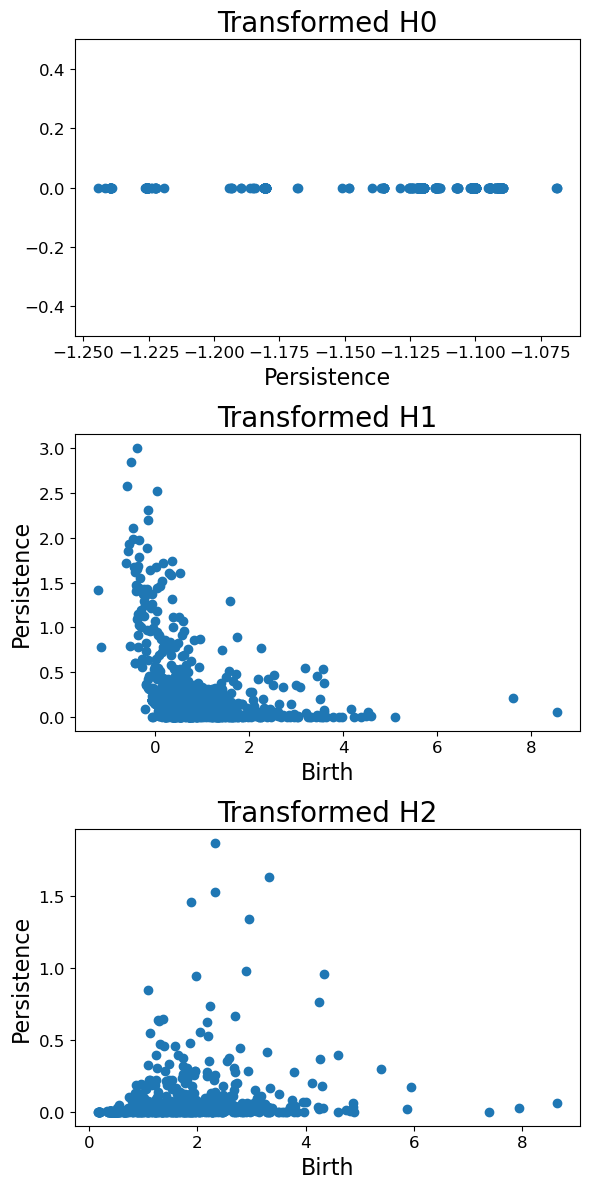

In [42]:
import matplotlib.pyplot as plt
path = './protein_pds/EEHEE_rd1_0796.pkl'
filter_type = 'all'  # use all of the persistence pairs from the PD
subsample_size = 'all'  # use all

# load in raw H_0 diagrams
pd_h_0 = np.load(path, allow_pickle=True)[0][:-1,1:]  # remove the infinite persistence pair

# load in raw H_1 diagrams
pd_h_1 = np.load(path, allow_pickle=True)[1]

# load in raw H_2 diagrams
pd_h_2 = np.load(path, allow_pickle=True)[2]

h0_transformed, num_h_0_pairs_retained_train = preprocess_pd_array([pd_h_0], skew=True, filter=filter_type, t=subsample_size)
h1_transformed, num_h_1_pairs_retained_train = preprocess_pd_array([pd_h_1], skew=True, filter=filter_type, t=subsample_size)
h2_transformed, num_h_2_pairs_retained_train = preprocess_pd_array([pd_h_2], skew=True, filter=filter_type, t=subsample_size)
h0_transformed = h0_transformed[0]
h1_transformed = h1_transformed[0]
h2_transformed = h2_transformed[0]

# Create subplots with shared x-axis
fig, axs = plt.subplots(3, 1, figsize=(6, 12))

# Plot scatter plots on each axis
axs[0].scatter(h0_transformed, np.zeros((len(h0_transformed),1)))
axs[0].set_ylim(-0.5,0.5)
axs[0].set_xlabel('Persistence', fontsize=16)
axs[0].set_title('Transformed H0', fontsize=20)


axs[1].scatter(h1_transformed[:,0], h1_transformed[:,1])
axs[1].set_ylabel('Persistence', fontsize=16)
axs[1].set_xlabel('Birth', fontsize=16)
axs[1].set_title('Transformed H1', fontsize=20)

axs[2].scatter(h2_transformed[:,0], h2_transformed[:,1])
axs[2].set_xlabel('Birth', fontsize=16)
axs[2].set_ylabel('Persistence', fontsize=16)
axs[2].set_title('Transformed H2', fontsize=20)

# Increase tick label size
for ax in axs:
    ax.tick_params(axis='both', labelsize=12)

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.savefig('figures/sample_transformed_pd.svg', format='svg')
plt.savefig('figures/sample_transformed_pd.eps', format='eps')
plt.show()

## Train CDER based model and assess performance

### Train/Test split

In [ ]:
cder_perf_df = pandas.DataFrame(columns=['topology', 'iteration', 'train_median_num_pairs_retained',
                                              'test_median_num_pairs_retained', 'train_accuracy', 'test_accuracy',
                                              'roc_auc_test', 'aps', 'confusion_matrix', 'classifier_path', 
                                              'cder_models_path', 'runtime'])
filter_type = 'all'  # use all of the persistence pairs from the PD
subsample_size = 'all'  # use all of the persistence pairs from the PD
num_iterations = 10

start_time = time.time()
for topology in topologies_arr:
    for i in range(num_iterations):
        iter_time = time.time()
        topology_df = main_df[main_df['topology'] == topology]

        # split the data into training and a testing sets
        test_size = 0.2
        random_state =  i  # change random state for each iteration

        train_df = pandas.DataFrame()
        test_df = pandas.DataFrame()

        for l in ['red', 'green']:
            train, test = train_test_split(topology_df[topology_df['label']==l][['label', 'pd_path']],
                                           test_size=test_size, random_state=random_state)
            train_df = pandas.concat([train_df, train])
            test_df = pandas.concat([test_df, test])

        train_labels = train_df['label'].to_numpy()
        test_labels = test_df['label'].to_numpy()
        # load all persistence diagrams by dimension and by train/test split    
        train_h_0_all_pds = []
        train_h_1_all_pds = []
        train_h_2_all_pds = []
        test_h_0_all_pds = []
        test_h_1_all_pds = []
        test_h_2_all_pds = []

        # load in raw H_0 diagrams
        for path in train_df['pd_path']:
            pd_h_0 = np.load(path, allow_pickle=True)[0][:-1,1:]  # remove the infinite persistence pair
            train_h_0_all_pds.append(pd_h_0)

        for path in test_df['pd_path']:
            pd_h_0 = np.load(path, allow_pickle=True)[0][:-1,1:]  # remove the infinite persistence pair
            test_h_0_all_pds.append(pd_h_0)

        # load in raw H_1 diagrams
        for path in train_df['pd_path']:
            pd_h_1 = np.load(path, allow_pickle=True)[1]
            train_h_1_all_pds.append(pd_h_1)

        for path in test_df['pd_path']:
            pd_h_1 = np.load(path, allow_pickle=True)[1]
            test_h_1_all_pds.append(pd_h_1)

        # load in raw H_2 diagrams
        for path in train_df['pd_path']:
            pd_h_2 = np.load(path, allow_pickle=True)[2]
            train_h_2_all_pds.append(pd_h_2)

        for path in test_df['pd_path']:
            pd_h_2 = np.load(path, allow_pickle=True)[2]
            test_h_2_all_pds.append(pd_h_2)

        # Get all training and testing PDs together by homology class
        train_proc_h_0_all_pds, num_h_0_pairs_retained_train = preprocess_pd_array(train_h_0_all_pds, skew=True, filter=filter_type, t=subsample_size)
        train_proc_h_1_all_pds, num_h_1_pairs_retained_train = preprocess_pd_array(train_h_1_all_pds, skew=True, filter=filter_type, t=subsample_size)
        train_proc_h_2_all_pds, num_h_2_pairs_retained_train = preprocess_pd_array(train_h_2_all_pds, skew=True, filter=filter_type, t=subsample_size)
        test_proc_h_0_all_pds, num_h_0_pairs_retained_test = preprocess_pd_array(test_h_0_all_pds, skew=True, filter=filter_type, t=subsample_size)
        test_proc_h_1_all_pds, num_h_1_pairs_retained_test = preprocess_pd_array(test_h_1_all_pds, skew=True, filter=filter_type, t=subsample_size)
        test_proc_h_2_all_pds, num_h_2_pairs_retained_test = preprocess_pd_array(test_h_2_all_pds, skew=True, filter=filter_type, t=subsample_size)

        # Calculate the median number of persistence pairs retained for train/test data for each shape class
        pairs_retained_train_df = pandas.DataFrame(train_df['label'])
        pairs_retained_train_df = pairs_retained_train_df.reset_index(drop=True)
        pairs_retained_train_df = pandas.concat([pairs_retained_train_df,
                                                 pandas.DataFrame(num_h_0_pairs_retained_train, columns=['train_h_0_pairs']),
                                                 pandas.DataFrame(num_h_1_pairs_retained_train, columns=['train_h_1_pairs']),
                                                 pandas.DataFrame(num_h_2_pairs_retained_train, columns=['train_h_2_pairs'])],
                                                axis=1)

        pairs_retained_test_df = pandas.DataFrame(test_df['label'])
        pairs_retained_test_df = pairs_retained_test_df.reset_index(drop=True)
        pairs_retained_test_df = pandas.concat([pairs_retained_test_df,
                                                 pandas.DataFrame(num_h_0_pairs_retained_test, columns=['test_h_0_pairs']),
                                                 pandas.DataFrame(num_h_1_pairs_retained_test, columns=['test_h_1_pairs']),
                                                 pandas.DataFrame(num_h_2_pairs_retained_test, columns=['test_h_2_pairs'])],
                                                axis=1)

        median_train_pairs_retained_dict = pairs_retained_train_df.groupby('label').median(numeric_only=True).to_dict()
        median_test_pairs_retained_dict = pairs_retained_test_df.groupby('label').median(numeric_only=True).to_dict()

        # Train CDER models
        models_path = 'cder_models/'
        h0_file = models_path + f'{topology}_cder_h0_model_iteration_{i}.pickle'
        h1_file = models_path + f'{topology}_cder_h1_model_iteration_{i}.pickle'
        h2_file = models_path + f'{topology}_cder_h2_model_iteration_{i}.pickle'
        tic = time.time()
        _, h0_proc_pd_cder_model = gen_cder_model(train_proc_h_0_all_pds, train_labels, 
                                                  stop_level=None, parsimonious=True,
                                                  full_ct=True, out_file=h0_file)
        print('Finished training H_0 CDER model in time', time.time()-tic, 'seconds')

        tic = time.time()
        _, h1_proc_pd_cder_model = gen_cder_model(train_proc_h_1_all_pds, train_labels, 
                                                  stop_level=None, parsimonious=True,
                                                  full_ct=True, out_file=h1_file)
        print('Finished training H_1 CDER model in time', time.time()-tic, 'seconds')

        tic = time.time()
        _, h2_proc_pd_cder_model = gen_cder_model(train_proc_h_2_all_pds, train_labels, 
                                                  stop_level=None, parsimonious=True,
                                                  full_ct=True, out_file=h2_file)
        print('Finished training H_2 CDER model in time', time.time()-tic, 'seconds')

        # Save CDER models
        cder_models = {}
        cder_models[0] = h0_proc_pd_cder_model
        cder_models[1] = h1_proc_pd_cder_model
        cder_models[2] = h2_proc_pd_cder_model

        # Create cder models into a dataframe
        cder_model_0_df = pandas.DataFrame(cder_models[0].gaussians)
        cder_model_1_df = pandas.DataFrame(cder_models[1].gaussians)
        cder_model_2_df = pandas.DataFrame(cder_models[2].gaussians)
        
        # Create column to uniquely label each gaussian
        cder_model_0_df['name'] = 'H_0_'+cder_model_0_df['label']+cder_model_0_df['mean'].apply(round_array).map(str)
        cder_model_1_df['name'] = 'H_1_'+cder_model_1_df['label']+cder_model_1_df['mean'].apply(round_array).map(str)
        cder_model_2_df['name'] = 'H_2_'+cder_model_2_df['label']+cder_model_2_df['mean'].apply(round_array).map(str)
    
        # Create dataframe with each row as the H_0, H_1, and H_2 cder evaluation outputs
        train_h_0_raw_evals , _ , _ , = cder_models[0].runit(train_proc_h_0_all_pds)
        train_h_1_raw_evals , _ , _ , = cder_models[1].runit(train_proc_h_1_all_pds)
        train_h_2_raw_evals , _ , _ , = cder_models[2].runit(train_proc_h_2_all_pds)

        test_h_0_raw_evals , _ , _ , = cder_models[0].runit(test_proc_h_0_all_pds)
        test_h_1_raw_evals , _ , _ , = cder_models[1].runit(test_proc_h_1_all_pds)
        test_h_2_raw_evals , _ , _ , = cder_models[2].runit(test_proc_h_2_all_pds)

        temp_df = pandas.DataFrame(columns = ['true_label'])
        temp_df['true_label'] = train_df['label']
        temp_df = temp_df.reset_index(drop=True)  # drop the index so that the concat won't mix up the labels and the cder output vectors
        train_cder_output_df = pandas.concat([temp_df, 
                       pandas.concat([pandas.DataFrame(train_h_0_raw_evals, columns=pandas.Index(cder_model_0_df['name'])), 
                                      pandas.DataFrame(train_h_1_raw_evals, columns=pandas.Index(cder_model_1_df['name'])), 
                                      pandas.DataFrame(train_h_2_raw_evals, columns=pandas.Index(cder_model_2_df['name']))], axis=1)],
                      axis=1)

        temp_df = pandas.DataFrame(columns = ['true_label'])
        temp_df['true_label'] = test_df['label']
        temp_df = temp_df.reset_index(drop=True)  # drop the index so that the concat won't mix up the labels and the cder output vectors
        test_cder_output_df = pandas.concat([temp_df, 
                       pandas.concat([pandas.DataFrame(test_h_0_raw_evals, columns=pandas.Index(cder_model_0_df['name'])), 
                                      pandas.DataFrame(test_h_1_raw_evals, columns=pandas.Index(cder_model_1_df['name'])), 
                                      pandas.DataFrame(test_h_2_raw_evals, columns=pandas.Index(cder_model_2_df['name']))], axis=1)],
                      axis=1)
        
        # Rescale and standardize the features
        feature_scaler = StandardScaler()
        train_standardized_features = pandas.DataFrame(feature_scaler.fit_transform(train_cder_output_df.drop('true_label', axis=1)))
        train_standardized_features = pandas.concat((train_cder_output_df['true_label'], train_standardized_features), axis=1)
        test_standardized_features = pandas.DataFrame(feature_scaler.fit_transform(test_cder_output_df.drop('true_label', axis=1)))
        test_standardized_features = pandas.concat((test_cder_output_df['true_label'], test_standardized_features), axis=1)

        # Train and test ML model
        X_train = train_standardized_features.drop('true_label', axis=1)
        y_train = train_standardized_features['true_label']
        X_test = test_standardized_features.drop('true_label', axis=1)
        y_test = test_standardized_features['true_label']

        
        # =================== RF =========================
        # perform randomized search over rf hyperparameters
        
        # relabel classes from CDER colors to binary labels
        bin_labels_train = np.array([1 if label == 'green' else 0 for label in y_train])
        bin_labels_test = np.array([1 if label == 'green' else 0 for label in y_test])

        rf_clf = RandomForestClassifier(n_estimators=1000, class_weight='balanced')
        max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
        max_depth.append(None)
        rf_param_grid = {'max_features': sps.uniform, 
                         'max_depth': max_depth,
                         'min_samples_split': [2, 5, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4, 6, 8, 10]}

        rf_clf_gs = model_selection.RandomizedSearchCV(rf_clf, 
                                                       rf_param_grid,
                                                       scoring='average_precision', 
                                                       n_iter = 100,
                                                       cv=10, 
                                                       n_jobs=-1,
                                                       verbose=0)

        rf_clf_gs.fit(X_train, bin_labels_train)

        print('-- RF best params --')
        print(rf_clf_gs.best_params_)

        print('-- RF best APS --')
        print(rf_clf_gs.best_score_)
        
        classifier_path = f'classifiers/{topology}_cder_rf_clf_gs_{i}.pickle'
        with open(classifier_path, 'wb') as f:
            pickle.dump(rf_clf_gs, f, protocol=pickle.HIGHEST_PROTOCOL)
    
        # Get training accuracy
        y_train_pred = rf_clf_gs.predict(X_train)

        # Make predictions on test data using classifier
        y_pred = rf_clf_gs.predict(X_test)

        # Prepare performance metrics
        train_acc = metrics.accuracy_score(bin_labels_train, y_train_pred)
        test_acc = metrics.accuracy_score(bin_labels_test, y_pred)
        roc_auc = metrics.roc_auc_score(bin_labels_test, rf_clf_gs.predict_proba(X_test)[:, 1])
        aps = metrics.average_precision_score(bin_labels_test, rf_clf_gs.predict_proba(X_test)[:, 1])
        cm = confusion_matrix(bin_labels_test, y_pred)

        iter_runtime = time.time() - iter_time
        
        # Create row for cder_perf_df
        row = {'topology': topology,
               'iteration': i, 
               'subsample_size': subsample_size, 
               'train_median_num_pairs_retained': median_train_pairs_retained_dict,
               'test_median_num_pairs_retained': median_test_pairs_retained_dict,
               'train_accuracy': train_acc, 
               'test_accuracy': test_acc,
               'roc_auc_test': roc_auc,
               'aps': aps,
               'confusion_matrix': cm,
               'classifier_path': classifier_path, 
               'cder_models_path': [h0_file, h1_file, h2_file], 
               'runtime': iter_runtime}
        cder_perf_df.loc[len(cder_perf_df.index)] = row

        cder_perf_df.to_csv(f'./perf_dataframes/cder_perf_df_downsample.csv', index=False)
        print(f'Updated and saved cder_perf_df_downsample for this iteration in time {iter_runtime:.2f} seconds')

runtime = time.time() - start_time
print('Total runtime was', f'{runtime:.2f}', 'seconds')

Finished training H_0 CDER model in time 11901.55707526207 seconds
